<a href="https://colab.research.google.com/github/juanbeleno/meli-challenge-2020/blob/main/Meli_Challenge_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

[Mercado Libre Data Challenge 2020](https://ml-challenge.mercadolibre.com/) requires to build a ML model to predict the next item to be bought by a user based on his/her history of searches and views.

We start by installing the required libraries.



In [2]:
!pip install ujson==4.0.1
# !pip install transformers==3.4.0
!pip install torch==1.7.0
!pip install sentence-transformers==0.3.8
! pip install fastprogress
# https://github.com/UKPLab/sentence-transformers
!nvidia-smi

     |████████████████████████████████| 184kB 5.6MB/s 
     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 7.4MB/s 
     |████████████████████████████████| 3.0MB 29.7MB/s 
     |████████████████████████████████| 1.1MB 43.5MB/s 
     |████████████████████████████████| 890kB 46.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=2c9886613aabdce343f765e3407db11898a836005888bbfa44da88973fd0b390
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=09e53ce778d4f57e7983f82b7a1f4aa059474a2b7fb9991934d648e5b9b41e28
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
Tue Nov 17 02:30:58 2020       
+--------------------------

Make sure you don't get disconected

In [3]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

## Setup

We store on Google Drive the item data, sample submission file, test and train dataset.

In [4]:
# Setup Google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/recursos_colab/meli_challenge_2020/'

Mounted at /content/gdrive


Run the code below just once, there is no need to download the files on Google Drive more than once.

In [ ]:
# Download the files and store them in Google Drive
import requests
file_urls = {
    'test_dataset.jl.gz': 'https://meli-data-challenge.s3.amazonaws.com/2020/test_dataset.jl.gz',
    'train_dataset.jl.gz': 'https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz',
    'item_data.jl.gz': 'https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz',
    'sample_submission.csv': 'https://meli-data-challenge.s3.amazonaws.com/2020/sample_submission.csv'
}

# Source: https://stackoverflow.com/q/62285313
for file_name in file_urls:
  r = requests.get(file_urls[file_name], stream = True)
  with open(f'{root_path}{file_name}', "wb") as file:
      for block in r.iter_content(chunk_size = 1024):
          if block:
              file.write(block)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data exploration

The files have a Gzipped JSON Lines format and they use most of the RAM available on Google Colab (12GB), so I decided read the files line by line to save some RAM for model training usage. At this point, I'm only interested on two files: ```item_data.jl.gz``` and ```train_dataset.jl.gz```because they are used to train the model.

In [ ]:
import gzip
import ujson

def print_first_lines(file_path, n=5):
    """Print the frist line of JSON Line file using identation of 4"""
    with gzip.open(file_path,'rt') as f:
        for index, line in enumerate(f):
            data = ujson.loads(line)
            print(ujson.dumps(data, indent=4))
            if index >= n:
              break

def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b

def print_num_lines(file_path):
    """Count the number of lines in a file"""
    with gzip.open(file_path,'rb') as f:
        print(sum(bl.decode().count("\n") for bl in blocks(f)))


As we can see below, the training data is structured as a dictionary of purchases, searches and views associated with a item bought. We cannot see searches or purchases on the example below, but we know they exist because is shown on the [documentation](https://ml-challenge.mercadolibre.com/downloads) of the challenge. Also, we want to know the number of lines in this file because it's important to create DataLoader that will help us loading batches of records on training instead of loading all the dataset at the same time. There are ```413163``` lines in this file.

In [ ]:
print_first_line(f'{root_path}train_dataset.jl.gz')
print_num_lines(f'{root_path}train_dataset.jl.gz')
!wc -l gdrive/My Drive/recursos_colab/meli_challenge_2020/test_dataset.jl.gz
!sed -n '$=' gdrive/My Drive/recursos_colab/meli_challenge_2020/train_dataset.jl.gz

{
    "user_history": [
        {
            "event_info": 1786148,
            "event_timestamp": "2019-10-19T11:25:42.444-0400",
            "event_type": "view"
        },
        {
            "event_info": 1786148,
            "event_timestamp": "2019-10-19T11:25:57.487-0400",
            "event_type": "view"
        },
        {
            "event_info": "RELOGIO SMARTWATCH",
            "event_timestamp": "2019-10-19T11:26:07.063-0400",
            "event_type": "search"
        },
        {
            "event_info": 1615991,
            "event_timestamp": "2019-10-19T11:27:26.879-0400",
            "event_type": "view"
        },
        {
            "event_info": 1615991,
            "event_timestamp": "2019-10-19T11:28:36.558-0400",
            "event_type": "view"
        },
        {
            "event_info": 1615991,
            "event_timestamp": "2019-10-19T11:28:40.827-0400",
            "event_type": "view"
        },
        {
            "event_info": 1615991,
    

When the event type on the user history is a view or a purchase, then we have an ```event_info``` associated with an ```item_id``` on the file ```item_data.jl.gz``` that has the following information:

In [ ]:
print_first_lines(f'{root_path}item_data.jl.gz')

{
    "item_id": 111260,
    "title": "Casa Sola En Venta Con Gran Patio Solo Pago De Contado.",
    "domain_id": "MLM-INDIVIDUAL_HOUSES_FOR_SALE",
    "product_id": null,
    "price": "1150000.00",
    "category_id": "MLM170527",
    "condition": "new"
}
{
    "item_id": 871377,
    "title": "Resident Evil Origins Collection Nintendo Switch (en D3gamer",
    "domain_id": "MLM-VIDEO_GAMES",
    "product_id": "15270800",
    "price": "1392.83",
    "category_id": "MLM151595",
    "condition": "new"
}
{
    "item_id": 490232,
    "title": "Falda De Imitaci\u00f3n Piel Negra",
    "domain_id": "MLM-SKIRTS",
    "product_id": null,
    "price": "350.00",
    "category_id": "MLM7697",
    "condition": "new"
}
{
    "item_id": 1150706,
    "title": "Powercolor Red Devil Radeon Rx 580 8gb Gddr5",
    "domain_id": "MLM-GRAPHICS_CARDS",
    "product_id": null,
    "price": "3200.00",
    "category_id": "MLM9761",
    "condition": "used"
}
{
    "item_id": 934912,
    "title": "Laptop Hp Nx6320 

## Preparing the dataset

Before creating the dataset, we need to map the domains to indices that can be used in a multi-task model. Also, we need to structure the item data in a dictionary to access that info faster to augment the Dataset.

In [5]:
import gzip
import ujson

item_details = {}
file_path = f'{root_path}item_data.jl.gz'
with gzip.open(file_path,'rt') as f:
    for index, line in enumerate(f):
        data = ujson.loads(line)
        item_id = data['item_id']
        item_details[item_id] = data

Based on the idea that possibly not all the items in the set of item_details were bought in the training dataset. I will predict only the items and domains that appear in the training dataset. At the same time, I'm going to get some stats about the distribution of domains in the training set to know how oversample the minority of domains.



In [6]:
import gzip
import ujson

domain_map = {}
categories_map = {}
reduced_feature_map = {}
domain_freq = {}
top_items_per_domain = {}
file_path = f'{root_path}train_dataset.jl.gz'
with gzip.open(file_path,'rt') as f:
  for line in f:
    record = ujson.loads(line)
    item_id = record['item_bought']
    item = item_details[item_id]
    domain_id = item['domain_id']
    category_id = item['category_id']
    
    domain_freq[domain_id] = domain_freq.get(domain_id, 0) + 1

    if domain_id not in domain_map:
      domain_map[domain_id] = len(domain_map)

    if category_id not in categories_map:
      categories_map[category_id] = len(categories_map)

    # Creating the dependencies in the prediction
    if domain_id not in reduced_feature_map:
      reduced_feature_map[domain_id] = {}
    if item_id not in reduced_feature_map[domain_id]:
      reduced_feature_map[domain_id][item_id] = len(reduced_feature_map[domain_id])
    
    # Finding the most bought items per domain
    if domain_map[domain_id] not in top_items_per_domain:
      top_items_per_domain[domain_map[domain_id]] = {}
    top_items_per_domain[domain_map[domain_id]][item_id] = top_items_per_domain[domain_map[domain_id]].get(item_id, 0) + 1

    # Replace domain text for its numerical identifier
    #item_details[item_id]['domain_id'] = domain_map[domain_id]
    #item_details[item_id]['category_id'] = categories_map[category_id]
    #item_details[item_id]['feature_id'] = reduced_feature_map[domain_id][item_id]



In [ ]:
print(f'Items size: {len(item_details)}')
print(f'Domains size: {len(domain_map)}')
print(f'Categories size: {len(categories_map)}')
features_sizes = [len(reduced_feature_map[domain]) for domain in reduced_feature_map]
print(f'Min Features: {min(features_sizes)}')
print(f'Max Features: {max(features_sizes)}')
print(f'Average Features: {sum(features_sizes)/len(features_sizes)}')
sorted_freqs = {k: v for k, v in sorted(domain_freq.items(), key=lambda item: item[1], reverse=True)}
print(list(sorted_freqs.keys())[:5])
print(list(sorted_freqs.values())[:25])

Items size: 2102277
Domains size: 3214
Categories size: 4001
Min Features: 1
Max Features: 2576
Average Features: 20.20161792159303
['MLB-CELLPHONES', 'MLB-SNEAKERS', 'MLB-SUPPLEMENTS', 'MLB-HEADPHONES', 'MLB-SMARTWATCHES']
[25070, 14608, 9562, 9053, 7963, 4915, 4637, 4603, 4325, 4104, 3746, 3443, 3443, 3405, 3047, 2970, 2856, 2843, 2774, 2698, 2600, 2561, 2536, 2442, 2294]


P_90: 235


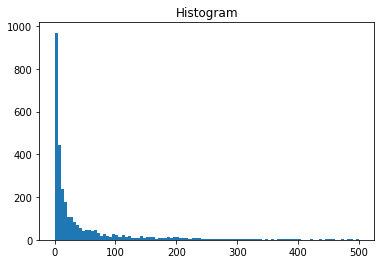

In [ ]:
import matplotlib.pyplot as plt
import math

freq_values = list(domain_freq.values())
freq_values.sort()
percentile = freq_values[math.ceil(len(freq_values)*90/100)]
print(f'P_90: {percentile}')

plt.hist(freq_values, bins=100, range=(0, 500))
plt.title("Histogram")
plt.show()

Oversample the 90% of the categories with fewer samples.

In [ ]:
import gzip
import ujson
import random
import math

train_lines = []
file_path = f'{root_path}train_dataset.jl.gz'
size_threshold = 235
with gzip.open(file_path,'rt') as f:
  for line in f:
    record = ujson.loads(line)
    item_id = record['item_bought']
    item = item_details[item_id]
    domain_id = item['domain_id']

    if domain_freq[domain_id] < size_threshold:
      # Oversampling
      num_samples = math.floor(size_threshold * 1.0 / domain_freq[domain_id])
      sample_probability = (size_threshold * 1.0 / domain_freq[domain_id]) - num_samples
      random_seed = random.uniform(0, 1)

      if num_samples > 0:
        for index in range(num_samples):
          train_lines.append(line)

      if random_seed <= sample_probability:
        train_lines.append(line)
    else:
      train_lines.append(line)

print(f'New dataset size: {len(train_lines)}')
random.shuffle(train_lines)

file_path = f'{root_path}train_dataset_oversampled.jl.gz'
with gzip.open(file_path, 'wt') as f:
  for index, line in enumerate(train_lines):
    new_line = line.strip(' \n\r\t')
    if index == 0:
      f.write(new_line)
    else:
      f.write(f'\n{new_line}')
train_lines = None


New dataset size: 999790


In [ ]:
file_path = f'{root_path}train_dataset_oversampled.jl.gz'
with gzip.open(file_path,'rt') as f:
  for index, line in enumerate(f):
    ujson.loads(line)
print(index)
#print_first_lines(f'{root_path}train_dataset_oversampled.jl.gz')

999789


**First dataset:** I'm planning to use only text as input, so I'll get the text on ```user_info```, when the ```event_type``` is a search and find the ```title``` on the ```item_data.jl.gz``` file when the ```event_type``` is a view or a purchase. Everything will be concatenated a single piece of text.

**Random ideas for improvement:**
* Remove duplicated ```item_id``` on the user_history
* Create one classifier for each domain_id
* Multi-task model for domain and for specific item
* CRF on top to avoid prediction of items that does not exist in a domain
* Oversample the 80% of the categories with fewer samples
* Weighted mean for the text embeddings

In [21]:
from torch.utils.data import Dataset
from sentence_transformers import SentenceTransformer
import gzip
import math
import numpy as np
import pandas as pd
import torch
import ujson
#torch.multiprocessing.set_start_method('spawn')# good solution !!!!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

class MultiTaskDataset(Dataset):
    def __init__(self, file_path, config):
        self.file_path = file_path
        self.config = config
        self.sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')
        self.sentence_model = self.sentence_model.to(device)
        self.f = gzip.open(self.file_path, 'r')

        # Source: https://github.com/pytorch/text/issues/130#issuecomment-510412877
        '''
        self.offset_dict = {}
        with gzip.open(self.file_path,'rb') as f:
            for index, line in enumerate(f):
                offset = f.tell()
                self.offset_dict[index] = offset
        '''

    def __len__(self):
        return self.config['data_size']
        #return math.floor(self.config['data_size'] / self.config['batch_size'])

    def __getitem__(self, idx):
        """Getting and preprocessing the inputs"""
        #offset = self.offset_dict[idx]
        if idx == 0:
            self.f.close()
            self.f = gzip.open(self.file_path, 'r')
            self.f.seek(0)
        response = {}

        #with gzip.open(self.file_path,'rt') as f:
        #   f.seek(offset)
        line = self.f.readline()
        raw_data = ujson.loads(line)
        user_history = self.normalize_user_history(raw_data['user_history'])
        item_bought = None
        if 'item_bought' in raw_data:
            item_bought = raw_data['item_bought']
        views = []
        searches = []
        # The embedding size produced by DISTILLBERT is 768
        #embedding_size = 768
        embedding_size = 300
        num_domains = 3214
        avg_view_embeddings = np.zeros(embedding_size)
        avg_search_embeddings = np.zeros(embedding_size)
        domain_embeddings = np.zeros(num_domains)
        if len(user_history) > 0:
            sentence_embeddings = []
            for item in user_history:
                # Store the text in the search and the title from the items
                # on purchases or views
                if item['event_type'] == 'search':
                    # I'm going to temporarily ignore the embeddings from
                    # searches
                    text = item['event_info']
                    searches.append(text)
                else:
                    #text_embedding = item_details[item['event_info']]['text_embeddings']
                    #sentence_embeddings.append(text_embedding)
                    domain_id = item_details[item['event_info']]['domain_id']
                    if domain_id in domain_map:
                      domain_embeddings[domain_map[domain_id]] = domain_embeddings[domain_map[domain_id]] + 1
                    text = item_details[item['event_info']]['title']
                    views.append(text)
            if len(views) > 0:
              view_embeddings = self.sentence_model.encode(views)
              avg_view_embeddings = self.embeddings_weighted_average(view_embeddings)
            if len(searches) > 0:
              search_embeddings = self.sentence_model.encode(searches)
              avg_search_embeddings = self.embeddings_weighted_average(search_embeddings)
        response['view_embeddings'] = avg_view_embeddings
        response['search_embeddings'] = avg_search_embeddings
        response['domain_embeddings'] = domain_embeddings
        if item_bought:
            item_data = item_details[item_bought]
            domain_id = item_data['domain_id']
            category_id = item_data['category_id']
            response['item'] = torch.tensor(
                reduced_feature_map[domain_id][item_bought], dtype=torch.long)
            response['domain'] = torch.tensor(
                domain_map[domain_id], dtype=torch.long)
            response['category'] = torch.tensor(
                categories_map[category_id], dtype=torch.long)
        return response

    def normalize_user_history(sefl, user_history):
      # Remove duplicated views and searches that appear almost at the same time
      new_user_history = []
      last_item_id = ''
      for item in user_history:
        current_item_id = item['event_info']
        if current_item_id != last_item_id:
          new_user_history.append(item)
        last_item_id = current_item_id
      # We are only going to consider the last 20 events
      return new_user_history[-20:]

    def embeddings_weighted_average(self, embeddings):
      # I'm going to use a logarithmic decrease in the importance of each
      # view or search according to its recency
      embeddings_size = embeddings.shape[0]
      avg_embeddings = embeddings
      if embeddings_size >= 1:
        weights = [1.0 / math.log2(2 + index) for index in range(embeddings_size)]
        normal_weigths = [float(w)/sum(weights) for w in weights]
        # The last item in the embeddings is the most recent
        normal_weigths = np.array(list(reversed(normal_weigths)))
        avg_embeddings = embeddings * normal_weigths.reshape((normal_weigths.size, 1))
        avg_embeddings = np.sum(avg_embeddings, axis=0)
      return avg_embeddings
        


Device: cuda:0


Get the data loader

In [33]:
from torch.utils.data import DataLoader
import numpy as np


# a simple custom collate function, just to show the idea
def my_collate(batch):
    searches = torch.from_numpy(np.array([item['search_embeddings'] for item in batch]))
    views = torch.from_numpy(np.array([item['view_embeddings'] for item in batch]))
    domain_views = torch.from_numpy(np.array([item['domain_embeddings'] for item in batch]))
    items = [item['item'] for item in batch]
    items = torch.LongTensor(items)
    domains = [item['domain'] for item in batch]
    domains = torch.LongTensor(domains)
    return [searches, views, domain_views, items, domains]

# a simple custom collate function, just to show the idea
def my_collate_test(batch):
    searches = torch.from_numpy(np.array([item['search_embeddings'] for item in batch]))
    views = torch.from_numpy(np.array([item['view_embeddings'] for item in batch]))
    domain_views = torch.from_numpy(np.array([item['domain_embeddings'] for item in batch]))
    return searches, views, domain_views

train_config = {
    'data_size': 999790,
    'batch_size': 64
}
ds = MultiTaskDataset(f'{root_path}train_dataset_oversampled.jl.gz', train_config)
# If I set up a different value than 0 (main process) for the
# num_workers parameter, then it stuck on a infinite loop
train_loader = DataLoader(
    ds, batch_size=train_config['batch_size'], num_workers=0,
    collate_fn=my_collate, pin_memory=True, shuffle=True)


test_config = {
    'data_size': 177070,
    'batch_size': 64
}
ds_test = MultiTaskDataset(f'{root_path}test_dataset.jl.gz', test_config)
test_loader = DataLoader(
    ds_test, batch_size=test_config['batch_size'], num_workers=0,
    collate_fn=my_collate_test, pin_memory=True)

#import time
#start = time.process_time()
#
#import cProfile
#cProfile.run('next(iter(train_loader))')
#%timeit print(time.process_time() - start)
# print(data)
#import pdb; pdb.set_trace()

## Creating the model

The model is the ```bert-case-uncased``` version of BERT provided by HugginFaces.

In [31]:
import torch.nn as nn
import torch


class MultiTaskModel(nn.Module):
    """
    Creates a MultiTask model for classifications of domains and items based on
    the same text
    """
    def __init__(self):
        super().__init__()
        #num_items = 2102277
        #num_item_mappings = 2576
        num_domains = 3214
        #embedding_size = 768
        embedding_size = 300

        # Inputs to hidden layer linear transformation
        #self.dropout = nn.Dropout(0.1)
        self.hidden_1 = nn.Linear(embedding_size*2 + num_domains, 512)
        self.hidden_1_relu = nn.ReLU()
        self.hidden_2 = nn.Linear(512, 256)
        self.hidden_2_relu = nn.ReLU()
        # Output layers
        # Items: 41420 units
        # Domains: 7894 units
        self.output_domains = nn.Linear(256, num_domains)
        #self.hidden_3 = nn.Linear(num_domains, 128)
        #self.hidden_2_relu = nn.ReLU()
        #self.output_items = nn.Linear(128, num_item_mappings)

        # Define the softmax output
        self.log_softmax_domains = nn.LogSoftmax(dim=1)
        #self.log_softmax_items = nn.LogSoftmax(dim=1)

    def forward(self, views, searches, domain_views):
        # Pass the input tensor through each of our operations
        inputs = torch.cat((views, searches, domain_views), dim=1)
        #x = self.dropout(inputs)
        x = self.hidden_1(inputs)
        x = self.hidden_1_relu(x)
        x = self.hidden_2(x)
        x = self.hidden_2_relu(x)

        x_domains = self.output_domains(x)
        y_domains = self.log_softmax_domains(x_domains)

        #x_items = self.hidden_3(x_domains)
        #x_items = self.hidden_2_relu(x_items)
        #x_items = self.output_items(x_items)
        #y_items = self.log_softmax_items(x_items)

        return y_domains

## Training


In [34]:
from fastprogress import master_bar, progress_bar
import torch.nn as nn
import torch.optim as optim
import time


# Define model
model = MultiTaskModel()
model = model.to(device)
# Define the loss
criterion = [nn.NLLLoss(), nn.NLLLoss()]
criterion[0] = criterion[0].to(device)
criterion[1] = criterion[1].to(device)
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


epochs = 2
mb = master_bar(range(epochs))
for epoch in mb:
    running_loss = 0
    print(f'Epoch: {epoch}')
    start_time = time.time()
    for views, searches, domain_views, items, domains in progress_bar(train_loader):
        #if index % 50 == 0:
        #    print(f'Batch load # {index} / {int(413163/256)}: {time.time() - start_time} seconds')

        # Get features, items and domains
        views = views.to(device)
        searches = searches.to(device)
        domain_views = domain_views.to(device)
        items = items.to(device)
        domains = domains.to(device)

        # Training pass
        optimizer.zero_grad()

        output_domains = model(views.float(), searches.float(), domain_views.float())
        #loss_items = criterion[0](output_items, items)
        loss_domains = criterion[0](output_domains, domains)
        #loss = loss_items + loss_domains
        loss = loss_domains

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        start_time = time.time()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

Epoch: 0


Training loss: 4.937114958558005
Epoch: 1


ValueError: ignored

Let's save our model

In [35]:
import torch

model_path = f'{root_path}model-0.8.pth'
torch.save(model.state_dict(), model_path)

## Prediction

Before sending the answer to this challenge, we need to see the format for the output.

In [ ]:
with open(f'{root_path}sample_submission.csv','r') as f:
    for index, line in enumerate(f):
        if index < 4:
            print(line)
print(f'Number of lines: {index + 1}')

654238,781750,558980,663439,1397720,1095079,798751,1141944,411021,138117

462167,1511283,928291,1907892,66135,54134,1090655,700291,63494,613724

2092880,1974491,1687910,371918,1659351,156119,578171,1407298,1378300,500637

614011,509284,181629,1544217,267392,409673,755307,1621679,767644,617841

Number of lines: 177070


Now, we can save our file

In [ ]:
# Optional
model_path = f'{root_path}model-0.8.pth'
model = MultiTaskModel()
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [36]:
def get_inverse_feature_map(features_map, domain_map):
    inv_features_map = {}
    for domain in features_map:
        for item in features_map[domain]:
            domain_id = domain_map[domain]
            item_id = features_map[domain][item]
            if domain_id not in inv_features_map:
                inv_features_map[domain_id] = {}
            if item_id not in inv_features_map[domain_id]:
                inv_features_map[domain_id][item_id] = item
    return inv_features_map

inv_features_map = get_inverse_feature_map(reduced_feature_map, domain_map)

# print(list(features_map['MLM-INDIVIDUAL_HOUSES_FOR_SALE'].keys())[0])
# print(features_map['MLM-INDIVIDUAL_HOUSES_FOR_SALE'][111260])
# print(domain_map['MLM-INDIVIDUAL_HOUSES_FOR_SALE'])
# print(inv_features_map[1234])

In [37]:
from collections import Counter

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []

    with torch.no_grad():
        for views, searches, domain_views in test_loader:
            views = views.to(device)
            searches = searches.to(device)
            domain_views = domain_views.to(device)

            domains = model(views.float(), searches.float(), domain_views.float())
            #_, preds_items = torch.topk(items, 20)
            _, preds_domains = torch.max(domains, dim=1)

            #preds_items = preds_items.tolist()
            preds = []
            for index, domain in enumerate(preds_domains.tolist()):
                subset_items = dict(Counter(top_items_per_domain[domain]).most_common(10))
                subset_items = list(subset_items.keys())
                while len(subset_items) < 10:
                  subset_items.append(subset_items[0])
                '''
                default_item = list(inv_features_map[domain].values())[0]
                subset_items = []
                for item_candidate in preds_items[index]:
                    item_id = inv_features_map[domain].get(item_candidate, None)
                    if item_id and len(subset_items) < 10:
                        subset_items.append(item_id)
                subset_items.extend([default_item] * (10 - len(subset_items)))
                '''
                preds.append(subset_items)

            predictions.extend(preds)
    return predictions

predictions = get_predictions(model, test_loader)

In [38]:
with open(f'{root_path}real_submission_0.8.csv','wb') as f:
    preds_str = '\n'.join([','.join([f'{y}' for y in x]) for x in predictions])
    f.write(preds_str.encode())

## References

* [BERT Text Classification Using Pytorch](https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b)
* [Multi-Task Learning with Pytorch and FastAI](https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855)
* [Configuring Google Colab Like A Pro](https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573)
* [Tuning a Multi-Task Pytorch Network on Fate Grand Order](https://towardsdatascience.com/tuning-a-multi-task-fate-grand-order-trained-pytorch-network-152cfda2e086)
* [An Overview of Multi-Task Learning in Deep Neural Networks](https://ruder.io/multi-task/)